In [11]:
using Revise, Plots, LinearAlgebra, LaTeXStrings, Random

In [12]:
includet("../../src/SparseSpikes.jl")
using .SparseSpikes

Define ground truth amplitudes and positions

In [13]:
domain = [0, 1]

x0 = [0.1, 0.5, 0.9]
a0 = [1.5, 0.8, -1.0]

μ0 = DiscreteMeasure(x0, a0)

DiscreteMeasure{Float64}([0.1, 0.5, 0.9], [1.5, 0.8, -1.0], 1, 3)

In [14]:
# Define noise level
noise_level = 0.05

# Seed for noise
Random.seed!(22)

TaskLocalRNG()

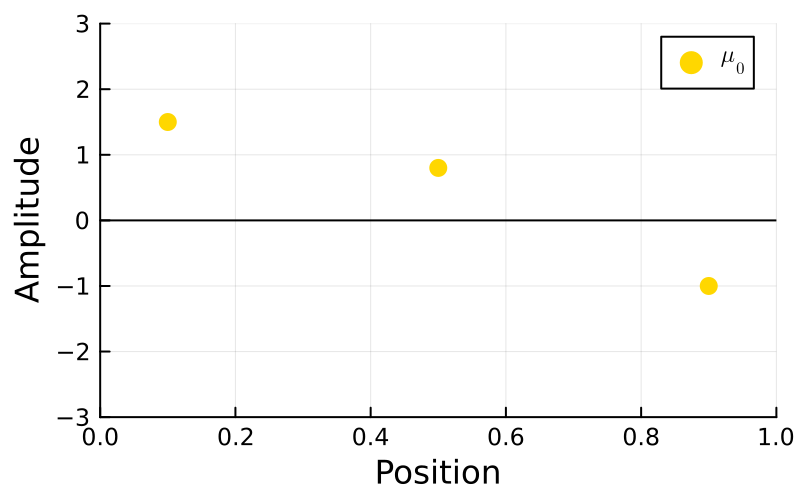

In [15]:
n_coarse_grid = 21
n_plt_grid = 1001

coarse_grid = grid(domain, n_coarse_grid)
plt_grid = grid(domain, n_plt_grid)


plot_size = (400, 250) .* 1
plt = plot(xlims=extrema(domain), ylims=(-3, 3), xlabel="Position", ylabel="Amplitude", legend=:topright, size=plot_size, dpi=200)
hline!(plt, [0], linestyle=:solid, color=:black, label="")

plot_spikes!(plt, μ0, label=L"μ_0", color=:gold)

In [16]:
ops = gaussian_operators_1D(.05, coarse_grid)

Operators(var"#ϕ#25"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, var"#gauss1D#24"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, var"#_gauss!#23"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Float64, Int64}, Int64}, Int64}(0.0:0.05:1.0, var"#gauss1D#24"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, var"#_gauss!#23"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Float64, Int64}, Int64}(0.0:0.05:1.0, var"#_gauss!#23"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Float64, Int64}(0.0:0.05:1.0, 400.0, 21), 21), 21), var"#Φ#26"{var"#ϕ#25"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, var"#gauss1D#24"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64},

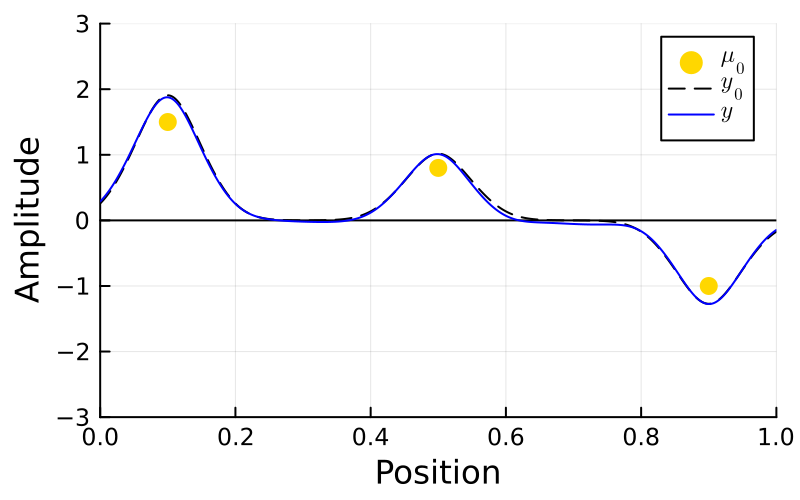

In [17]:
# Calculate the observation y0 = Φμ0
y0 = ops.Φ(μ0...)

# Add noise to the observation y = y0 + w
sigma = noise_level * norm(y0)
w = randn(length(y0))
w = w / norm(w) * sigma
y = y0 + w

plt_obs = deepcopy(plt)

plot!(plt_obs, plt_grid, ops.adjΦ(y0, grid=plt_grid), label=L"y_0", color=:black, linestyle=:dash)
plot!(plt_obs, plt_grid, ops.adjΦ(y, grid=plt_grid), label=L"y", color=:blue)

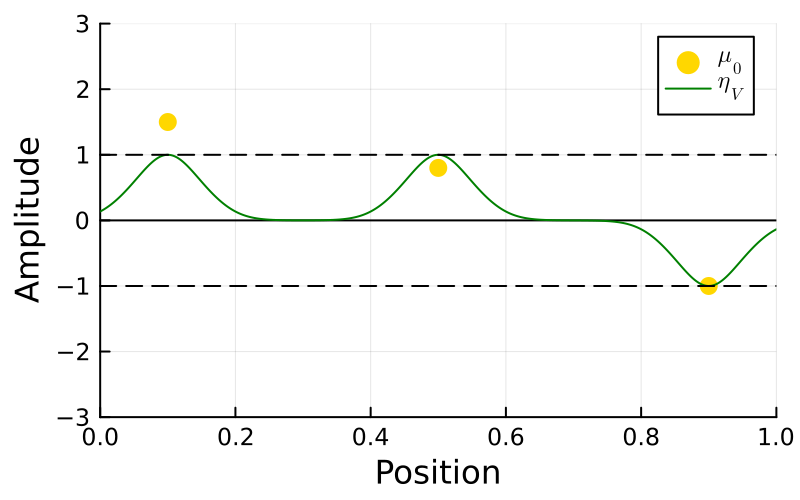

In [18]:
ηV = build_ηV(μ0, ops)

plt_cert = deepcopy(plt)

plot!(plt_cert, plt_grid, ηV(plt_grid), label=L"η_V", color=:green)
hline!(plt_cert, [1, -1], linestyle=:dash, color=:black, label="")

## Sliding Frank-Wolfe

In [21]:
# Define λ the regularisation parameter
λ = 0.07

prob_sfw = BLASSO(y, ops, domain, n_coarse_grid, λ=λ)

solve!(prob_sfw, :SFW)

BLASSO([0.04804211591953304, 0.5772844890492139, 1.47156409653313, 0.5191601738345063, 0.03435290279044291, -0.0008233229024100931, -0.012175084774361586, -0.020078061798625084, -0.0008724497336297325, 0.3047889092693992  …  0.258224902063172, -0.034780262416683694, -0.010697458129934828, -0.03366126091584781, -0.044711876652979085, 0.001999477747778901, -0.3588281333168815, -1.0054384196477981, -0.375029754824551, 0.011525887342889854], Operators(var"#ϕ#25"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, var"#gauss1D#24"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, var"#_gauss!#23"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Float64, Int64}, Int64}, Int64}(0.0:0.05:1.0, var"#gauss1D#24"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, var"#_gauss!#23"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwiceP

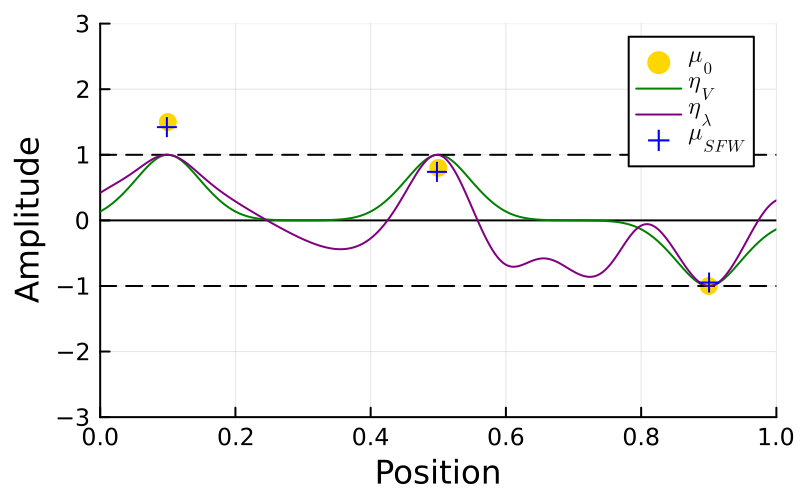

In [22]:
plt_sfw = deepcopy(plt_cert)

ηλ = prob_sfw.η(plt_grid)
plot!(plt_sfw, plt_grid, ηλ, label=L"η_λ", color=:purple)
plot_spikes!(plt_sfw, prob_sfw.μ, label=L"μ_{SFW}", color=:blue, marker=:cross, markerstrokewidth=2)